In [ ]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.7 MB/s eta 0:00:00


Trial 180 Complete [00h 00m 23s]
val_loss: 0.004994911607354879

Best val_loss So Far: 0.0019756194669753313
Total elapsed time: 00h 27m 24s
Best Hyperparameters after optimization: 
filters_1: 96
kernel_size_1: 5
filters_2: 32
kernel_size_2: 5
dropout_rate: 0.2
learning_rate: 0.006851781534735413
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0170
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0114
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 8/50
75/75 ━━

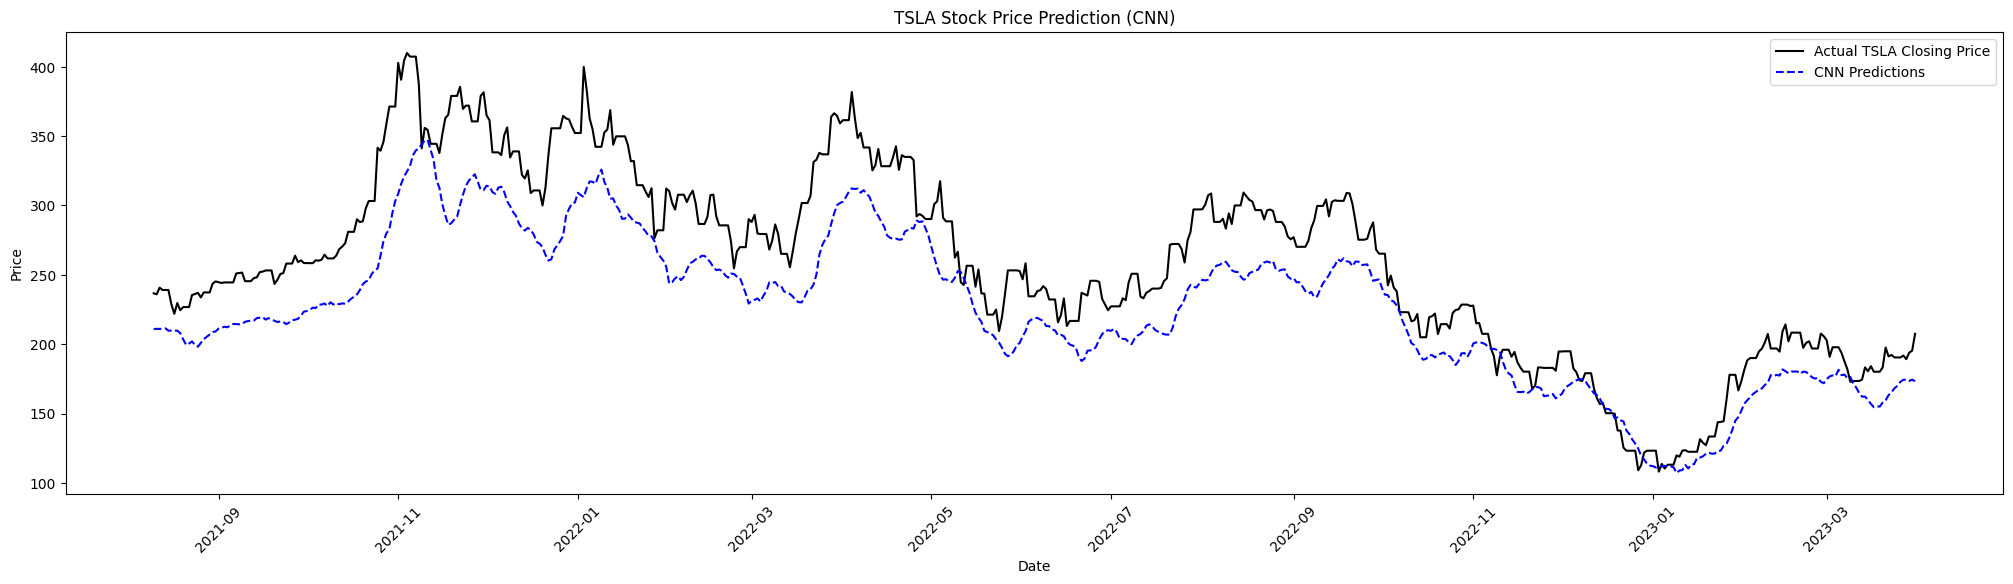

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt


file_path = 'dataset.csv'
df = pd.read_csv(file_path)

df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.sort_values('date').reset_index(drop=True)

encoder = LabelEncoder()
df['news_sentiment'] = encoder.fit_transform(df['news_sentiment'])

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['news_sentiment', 'opening price', 'high', 'low', 'volume traded', 'closing price']])


sequence_length = 20 
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, :-1])  
    y.append(scaled_data[i, -1])  
X, y = np.array(X), np.array(y)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

def build_model(hp):
    model = Sequential()

    model.add(Conv1D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Int('kernel_size_1', min_value=2, max_value=5, step=1),
                     activation='relu',
                     input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Int('kernel_size_2', min_value=2, max_value=5, step=1),
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Flatten())
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')),
                  loss='mean_squared_error')

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_loss', 
                     max_epochs=50,
                     factor=3,
                     hyperband_iterations=2,
                     directory='kt_dir',
                     project_name='stock_prediction')

tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]

best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

print("Best Hyperparameters after optimization: ")
for key, value in best_hyperparameters.items():
    print(f"{key}: {value}")

best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

cnn_predictions = best_model.predict(X_test)

cnn_predictions_inverse = scaler.inverse_transform(np.column_stack([np.zeros((len(cnn_predictions), 5)), cnn_predictions]))[:, -1]
real_prices = scaler.inverse_transform(np.column_stack([np.zeros((len(y_test), 5)), y_test]))[:, -1]

mse = mean_squared_error(real_prices, cnn_predictions_inverse)
mae = mean_absolute_error(real_prices, cnn_predictions_inverse)
r2 = r2_score(real_prices, cnn_predictions_inverse)

mape = np.mean(np.abs((real_prices - cnn_predictions_inverse) / real_prices)) * 100

correct_direction = np.sign(np.diff(real_prices)) == np.sign(np.diff(cnn_predictions_inverse))
pocid = np.mean(correct_direction) * 100

print(f'Mean Squared Error (CNN): {mse}')
print(f'Mean Absolute Error (CNN): {mae}')
print(f'R2 score (CNN): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Percentage of Correct Directional Change (POCID): {pocid}%')

test_dates = df['date'][-len(real_prices):]
plt.figure(figsize=(25, 6))
plt.plot(test_dates, real_prices, color='black', label='Actual TSLA Closing Price')
plt.plot(test_dates, cnn_predictions_inverse, color='blue', linestyle='dashed', label='CNN Predictions')
plt.title('TSLA Stock Price Prediction (CNN)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()
